## Student: Joe Fernandez
## Course: COMPSCIX459.5-009
## Project: Classification Project [Final Exam]
> Project Topic: RMS Titanic : Develop a predictive model to answer
>
> *"what sorts of people were more likely to survive?"*

## We will explore this using cross-validaton models on the following:

> <font size='4'>**Naive Bayes Analysis**</font>
>
> <font size='4'>**Logistic Regression**</font>
>
> <font size='4'>**Linear Support Vector Machine**</font>
>
> <font size='4'>**Random Forest**</font>
>
> <font size='4'>**Gradient Boosted Tree**</font>

In [1]:
import pyspark
from pyspark.ml.feature import PCA, VectorAssembler
from pyspark.mllib.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType

spark = SparkSession \
    .builder \
    .appName("Python Spark Final Project - Joe Fernandez") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

23/05/28 19:16:30 WARN Utils: Your hostname, Josephs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.120 instead (on interface en0)
23/05/28 19:16:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/28 19:16:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Read the Titanic training data from `train.csv`

In [2]:
titanic_train =  spark.read.format('csv')\
                       .options(header='true', \
                       inferschema='true')\
            .load("train.csv",header=True);

### Converting Passenger Id column to a String Type using cast

In [3]:
titanic_train = titanic_train.withColumn("PassengerId", titanic_train["PassengerId"]
                             .cast(StringType()))

In [4]:
titanic_train.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
PassengerId,891,446.0,257.3538420152301,1,99
Survived,891,0.3838383838383838,0.48659245426485753,0,1
Pclass,891,2.308641975308642,0.8360712409770491,1,3
Name,891,None,None,"""Andersson, Mr. August Edvard (""""Wennerstrom"""")""","van Melkebeke, Mr. Philemon"
Sex,891,None,None,female,male
Age,714,29.69911764705882,14.526497332334035,0.42,80.0
SibSp,891,0.5230078563411896,1.1027434322934315,0,8
Parch,891,0.38159371492704824,0.8060572211299488,0,6
Ticket,891,260318.54916792738,471609.26868834975,110152,WE/P 5735


### Display the first 5 rows of the Spark DataFrame

In [5]:
titanic_train.toPandas().head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,None,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,None,C


In [6]:
titanic_train.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [7]:
titanic_header = titanic_train.columns
titanic_header

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [8]:
# There are 12 columns that provide various information about the passengers
total_cols = len(titanic_train.columns)
total_cols

12

In [9]:
# There are a total of 891 rows of data. Some of this data is missing information.
# We will review them later and reduce the number of rows used for processing

total_rows = titanic_train.count()
total_rows

891

### Let's find out how many null values are in each of the columns

In [10]:
print('The following columns have Null values')

for colname in titanic_header:
    if titanic_train.toPandas()[colname].isna().any():
        colnulls = titanic_train.toPandas()[colname].isna().sum()
        print('{} has {} nulls out of {}'.format(colname,colnulls,total_rows))


The following columns have Null values
Age has 177 nulls out of 891
Cabin has 687 nulls out of 891
Embarked has 2 nulls out of 891


### Titanic Dataset : Columns and Definitions

|Columns|Definition | Key
|:-|:-|:-|
|PassengerId|Passenger Id|
|Survived|Survival|0 = No, 1 = Yes
|pclass|Ticket class|1 = 1st, 2 = 2nd, 3 = 3rd
|sex|Sex|	
|Age|Age in years|
|sibsp|# of siblings / spouses aboard the Titanic	
|parch|# of parents / children aboard the Titanic	
|ticket|Ticket number	
|fare|Passenger fare	
|cabin|Cabin number	
|embarked|Port of Embarkation|C = Cherbourg, Q = Queenstown, S = Southampton

#### Cabin Number: Let's explore this
> Cabin Number is denoted as Xnnn where X is type of Cabin and nnn is the number \
> We can try and remove the number and focus only on the Cabin Type \
> See if this improves the prediction
>
> I tried this approach but the prediction accuracy reduced. It is better to have the whole Cabin Number \
> Instead of having just the Cabin Types
>
> Below is the code to extract only the Cabin Type and remove the Cabin column

In [11]:
# I tried to explore if we can use only Cabin Type instead of Cabin column

# To use only Cabin Type instead of the full Cabin column: We can split and take only the first char value
# all valid cabins have Xnnn value where X is Cabin Type and nnn is the Cabin Number

#from pyspark.sql.functions import split, element_at, regexp_extract

#titanic_train = titanic_train.withColumn("CabinType", regexp_extract("Cabin", "(\D)", 0)).drop("Cabin")
#titanic_train.toPandas().head()

In [12]:
titanic_train.first()

Row(PassengerId='1', Survived=0, Pclass=3, Name='Braund, Mr. Owen Harris', Sex='male', Age=22.0, SibSp=1, Parch=0, Ticket='A/5 21171', Fare=7.25, Cabin=None, Embarked='S')

### Let's drop all the rows that have incomplete data 
### Dropping all NaN so we can work with only complete data

In [13]:
titanic_train = titanic_train.dropna()

In [14]:
titanic_train.count()

183

### Split the Columns to Categorical Columns, Numeric Columns, and Label Columns

In [15]:
catcols=[]
num_cols=[]
labelCol = 'Survived'

for i in titanic_train.dtypes:
    if i[1] == 'string':
        catcols.append(i[0])
    elif i[0] != 'Survived':
        num_cols.append(i[0])


In [16]:
catcols

['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [17]:
num_cols

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [18]:
labelCol

'Survived'

### Summarize Columns

In [19]:
def describe_columns(df):
    for i in num_cols:
        print('Column: ' + i)
        df.select(i).describe().show()

### Describe Numeric Columns to get statistical values
#### Excludes Survived as it is now the Label to predict

In [20]:
describe_columns(titanic_train)

Column: Pclass
+-------+------------------+
|summary|            Pclass|
+-------+------------------+
|  count|               183|
|   mean|1.1912568306010929|
| stddev|0.5151869975715835|
|    min|                 1|
|    max|                 3|
+-------+------------------+

Column: Age
+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               183|
|   mean|  35.6744262295082|
| stddev|15.643865966849717|
|    min|              0.92|
|    max|              80.0|
+-------+------------------+

Column: SibSp
+-------+------------------+
|summary|             SibSp|
+-------+------------------+
|  count|               183|
|   mean|0.4644808743169399|
| stddev|0.6441585604537324|
|    min|                 0|
|    max|                 3|
+-------+------------------+

Column: Parch
+-------+-------------------+
|summary|              Parch|
+-------+-------------------+
|  count|                183|
|   mean|0.47540983606557374|
| stddev|

## Process categorical columns

The following code does three things with pipeline:

* **`StringIndexer`** all categorical columns
* **`OneHotEncoder`** all categorical index columns
* **`VectorAssembler`** all feature columns into one vector column

### Categorical columns: Create String Indexer, One Hot Encoder, and Vector Assembler

In [21]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col

In [22]:
indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c)) for c in catcols]
#indexers += [StringIndexer(inputCol='Survived', outputCol='label')]

In [23]:
encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(), \
                           outputCol="{0}_encoded".format(indexer.getOutputCol())) \
                           for indexer in indexers]

In [24]:
assembler = VectorAssembler(inputCols=[encoder.getOutputCol() \
                    for encoder in encoders] + num_cols, outputCol="features")

### Create the Pipeline and Model to apply on all the ML modules

> We are going to convert all the data into two columns : Features and Labels\
> Features will take all the categorical and numeric data to create a feature extract\
> We are going to assiign the label we already know. Values are: 0 = Did not survive, 1 = Survived
>
> A Pipeline consists of a sequence of stages, each of which is either an Estimator or a Transformer
>
> Transformer: A Transformer is an algorithm which can transform one DataFrame into another DataFrame. E.g., an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.
>
>Estimator: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. E.g., a learning algorithm is an Estimator which trains on a DataFrame and produces a model.
>
>Pipeline: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.

The figure below is for the training time usage of a Pipeline.

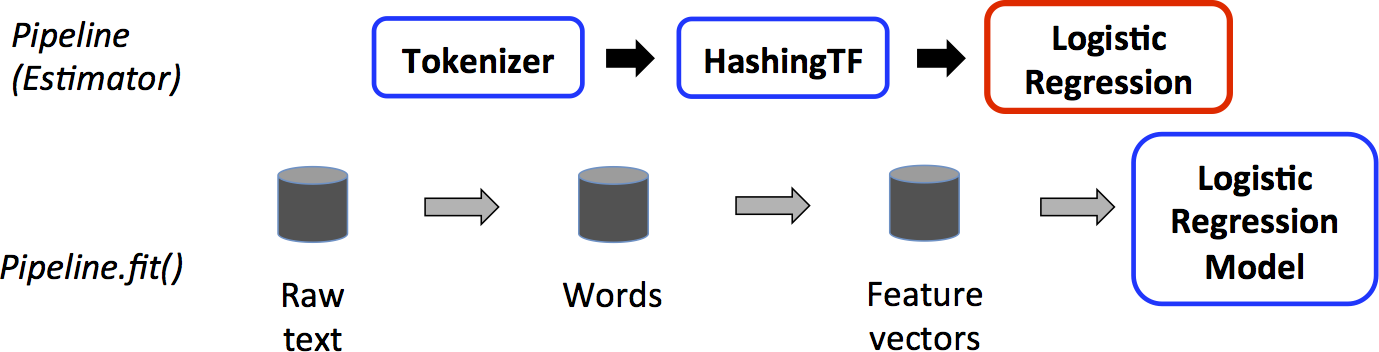

Reference: https://spark.apache.org/docs/latest/ml-pipeline.html (Spark Apace Website)

In [25]:
pipeline = Pipeline(stages=indexers + encoders + [assembler])
model=pipeline.fit(titanic_train)
data = model.transform(titanic_train)
data = data.withColumn('label',col(labelCol))
data=data.select('features','label')
data.show(5, truncate=False)

+----------------------------------------------------------------------------------------+-----+
|features                                                                                |label|
+----------------------------------------------------------------------------------------+-----+
|(630,[19,238,481,583,624,625,626,627,629],[1.0,1.0,1.0,1.0,1.0,1.0,38.0,1.0,71.2833])   |1    |
|(630,[70,256,379,508,623,625,626,627,629],[1.0,1.0,1.0,1.0,1.0,1.0,35.0,1.0,53.1])      |1    |
|(630,[136,297,364,446,615,623,625,626,629],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,54.0,51.8625])  |0    |
|(630,[1,331,405,493,623,625,626,627,628,629],[1.0,1.0,1.0,1.0,1.0,3.0,4.0,1.0,1.0,16.7])|1    |
|(630,[4,217,427,563,623,625,626,629],[1.0,1.0,1.0,1.0,1.0,1.0,58.0,26.55])              |1    |
+----------------------------------------------------------------------------------------+-----+
only showing top 5 rows



### Having run this multiple times with various split options for training / test

> Here are my findings:
>
> The best option are as follows:\
> maxCategories = 4 and Training & Test split = 60% and 40%

### Create the indexedFeatures for processing

In [26]:
from pyspark.ml.feature import VectorIndexer
# Here I am trying to automatically identify the categorical features
# and index them. I am setting maxCategories to 4 
# (The more categories, the accuracy reduces; 4 seems to be the best at 60% Training & 40% Test)
# Best accuracy score reached was 74% on a few tries

featureIndexer =VectorIndexer(inputCol="features", \
                                  outputCol="indexedFeatures", \
                                  maxCategories=4).fit(data)

In [27]:
# Now I have the feature Indexer to start doing the training and test
data=featureIndexer.transform(data)
data.show(5)

+--------------------+-----+--------------------+
|            features|label|     indexedFeatures|
+--------------------+-----+--------------------+
|(630,[19,238,481,...|    1|(630,[19,238,481,...|
|(630,[70,256,379,...|    1|(630,[70,256,379,...|
|(630,[136,297,364...|    0|(630,[136,297,364...|
|(630,[1,331,405,4...|    1|(630,[1,331,405,4...|
|(630,[4,217,427,5...|    1|(630,[4,217,427,5...|
+--------------------+-----+--------------------+
only showing top 5 rows



### Split the data to training and test data sets

In [28]:
# Split the data into training and test sets (40% held out for testing)
(trainingData, testData) = data.randomSplit([0.6, 0.4])
trainingData.show(5,False)
testData.show(5,False)

+--------------------------------------------------------------------------------------------+-----+--------------------------------------------------------------------------------------------+
|features                                                                                    |label|indexedFeatures                                                                             |
+--------------------------------------------------------------------------------------------+-----+--------------------------------------------------------------------------------------------+
|(630,[0,361,364,392,518,623,625,626,628,629],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,21.0,1.0,77.2875])|0    |(630,[0,361,364,392,518,623,625,626,628,629],[1.0,1.0,1.0,1.0,1.0,1.0,0.0,21.0,1.0,77.2875])|
|(630,[2,323,364,407,565,623,625,626,629],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,47.0,52.0])           |0    |(630,[2,323,364,407,565,623,625,626,629],[1.0,1.0,1.0,1.0,1.0,1.0,0.0,47.0,52.0])           |
|(630,[6,360,364,392,518,623,6

## Build cross-validation model


## Cross-Validation

In general, one round of cross-validation involves partitioning a sample of data into complementary subsets, performing the analysis on one subset (called the training set), and validating the analysis on the other subset (called the validation set or testing set).
CrossValidator begins by splitting the dataset into a set of folds which are used as separate training and test datasets. E.g., with k=3 folds, CrossValidator will generate 3 (training, test) dataset pairs, each of which uses 2/3 of the data for training and 1/3 for testing. To evaluate a particular ParamMap, CrossValidator computes the average evaluation metric for the 3 Models produced by fitting the Estimator on the 3 different (training, test) dataset pairs.

After identifying the best ParamMap, CrossValidator finally re-fits the Estimator using the best ParamMap and the entire dataset.  In simple term, pickup the ParamMap that produces the best model and to use that model for subsequent transform().

## We will be running the cross-validaton models on the following:

> <font size='4'>**Naive Bayes Analysis**</font>
>
> <font size='4'>**Logistic Regression**</font>
>
> <font size='4'>**Linear Support Vector Machine**</font>
>
> <font size='4'>**Random Forest**</font>
>
> <font size='4'>**Gradient Boosted Tree**</font>

## Confusion Matrix

### For every prediction, we have 6 key things to look at:
- False Positive
- False Negative
- True Negative
- True Positive
- Accuracy
- Precision

Reference: https://neptune.ai/blog/evaluation-metrics-binary-classification

### False Positive Rate | Type I error

When we predict something when it isn’t we are contributing to the false positive rate. You can think of it as a fraction of false alerts that will be raised based on your model predictions

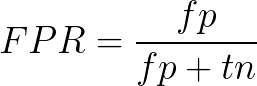

### False Negative Rate | Type II error

When we don’t predict something when it is, we are contributing to the false negative rate. You can think of it as a fraction of missed fraudulent transactions that your model lets through.

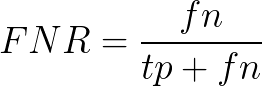

### True Negative Rate | Specificity

It measures how many observations out of all negative observations have we classified as negative. In our fraud detection example, it tells us how many transactions, out of all non-fraudulent transactions, we marked as clean.

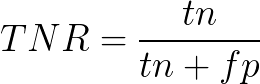

### True Positive Rate | Recall | Sensitivity

It measures how many observations out of all positive observations have we classified as positive. It tells us how many fraudulent transactions we recalled from all fraudulent transactions.

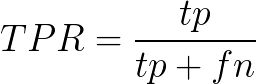

### Accuracy
It measures how many observations, both positive and negative, were correctly classified.

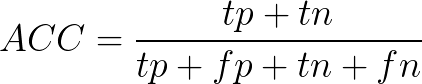

### Positive Predictive Value | Precision

It measures how many observations predicted as positive are in fact positive. Taking our fraud detection example, it tells us what is the ratio of transactions correctly classified as fraudulent.

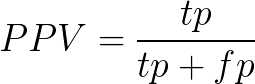

## Cross-Valitation Model on : Naive Bayes Analysis

Naive Bayes is a probabilistic machine learning algorithm based on the Bayes Theorem, used in a wide variety of classification tasks. Using Bayes theorem, we can find the probability of A happening, given that B has occurred. Here, B is the evidence and A is the hypothesis. The assumption made here is that the predictors/features are independent. That is presence of one particular feature does not affect the other. Hence it is called naive.

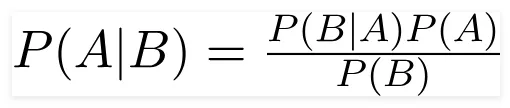

In [29]:
from pyspark.ml.classification import NaiveBayes
naivebayes = NaiveBayes(featuresCol="indexedFeatures", labelCol="label")

In [30]:
# Train the model for Naive Bayes Analysis model.  This also runs the indexers.
nb_model = naivebayes.fit(trainingData)

In [31]:
# Make predictions.
nb_predictions = nb_model.transform(testData)
# Select example rows to display. 
nb_predictions.select("features","label","indexedFeatures","prediction","rawPrediction").show(5)
#nb_predictions.show(5, False)

+--------------------+-----+--------------------+----------+--------------------+
|            features|label|     indexedFeatures|prediction|       rawPrediction|
+--------------------+-----+--------------------+----------+--------------------+
|(630,[1,331,405,4...|    1|(630,[1,331,405,4...|       1.0|[-78.342289069743...|
|(630,[3,202,364,3...|    0|(630,[3,202,364,3...|       1.0|[-249.06265831344...|
|(630,[4,217,427,5...|    1|(630,[4,217,427,5...|       0.0|[-126.78657526394...|
|(630,[5,359,456,5...|    1|(630,[5,359,456,5...|       0.0|[-93.435322314522...|
|(630,[7,312,432,5...|    1|(630,[7,312,432,5...|       0.0|[-91.337714943051...|
+--------------------+-----+--------------------+----------+--------------------+
only showing top 5 rows



In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
nb_accuracy = evaluator.evaluate(nb_predictions)
print(f"Accuracy = {nb_accuracy}")
print("Test Error = %g" % (1.0 - nb_accuracy))

Accuracy = 0.691358024691358
Test Error = 0.308642


In [33]:
print('training data (f1):', evaluator.setMetricName('f1').evaluate(nb_predictions), "\n",
     'training data (weightedPrecision): ', evaluator.setMetricName('weightedPrecision').evaluate(nb_predictions),"\n",
     'training data (weightedRecall): ', evaluator.setMetricName('weightedRecall').evaluate(nb_predictions),"\n",
     'training data (accuracy): ', evaluator.setMetricName('accuracy').evaluate(nb_predictions))

training data (f1): 0.6991794603006276 
 training data (weightedPrecision):  0.7170548073325851 
 training data (weightedRecall):  0.691358024691358 
 training data (accuracy):  0.691358024691358


### Get Confusion Matrix

In [34]:
y_pred=nb_predictions.select("prediction").collect()
y_orig=nb_predictions.select("label").collect()

In [35]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[17  9]
 [16 39]]


In [36]:
tn, fp, fn, tp = cm.ravel()

false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
recall = recall_score(y_orig, y_pred)

print('For Naive Bayes Analysis :\n')
print('The false positive or type I error  rate is {}'.format(false_negative_rate))
print('The false negative or type II error rate is {}'.format(false_positive_rate))
print('The true negative or sensitivity    rate is {}'.format(true_negative_rate))
print('The true positive or recall         rate is {}'.format(recall))

For Naive Bayes Analysis :

The false positive or type I error  rate is 0.2909090909090909
The false negative or type II error rate is 0.34615384615384615
The true negative or sensitivity    rate is 0.6538461538461539
The true positive or recall         rate is 0.7090909090909091


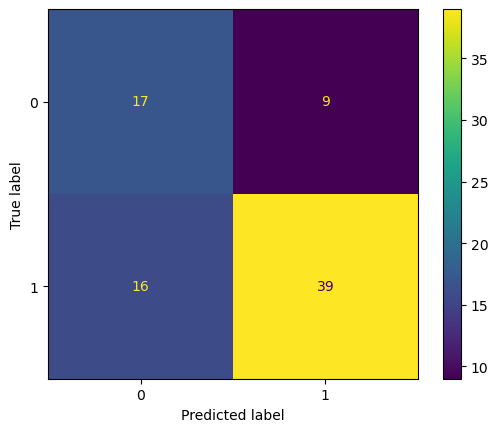

In [37]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Cross-Valitation Model on : Logistic Regression

Logistic regression is a popular method to predict a categorical response. It is a special case of Generalized Linear models that predicts the probability of the outcomes. In spark.ml logistic regression can be used to predict a binary outcome by using binomial logistic regression, or it can be used to predict a multiclass outcome by using multinomial logistic regression.

In [38]:
from pyspark.ml.classification import LogisticRegression
logr = LogisticRegression(featuresCol='indexedFeatures', labelCol='label')

In [39]:
# Train the model for logistic regression model.  This also runs the indexers.
lg_model = logr.fit(trainingData)

23/05/28 19:16:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/05/28 19:16:57 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
23/05/28 19:16:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/28 19:16:57 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [40]:
# Make predictions on the Test Data
lg_predictions = lg_model.transform(testData)
# Select example rows to display from the Test Data
lg_predictions.select("features","indexedFeatures","label","prediction","rawPrediction").show(5)


+--------------------+--------------------+-----+----------+--------------------+
|            features|     indexedFeatures|label|prediction|       rawPrediction|
+--------------------+--------------------+-----+----------+--------------------+
|(630,[1,331,405,4...|(630,[1,331,405,4...|    1|       1.0|[-9.7465647014016...|
|(630,[3,202,364,3...|(630,[3,202,364,3...|    0|       1.0|[-6.5903142085768...|
|(630,[4,217,427,5...|(630,[4,217,427,5...|    1|       1.0|[-5.3137100220767...|
|(630,[5,359,456,5...|(630,[5,359,456,5...|    1|       1.0|[-6.4149030186259...|
|(630,[7,312,432,5...|(630,[7,312,432,5...|    1|       1.0|[-6.7004060868336...|
+--------------------+--------------------+-----+----------+--------------------+
only showing top 5 rows



In [41]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
lg_accuracy = evaluator.evaluate(lg_predictions)
print(f"Accuracy = {lg_accuracy}")
print("Test Error = %g" % (1.0 - lg_accuracy))

Accuracy = 0.6666666666666666
Test Error = 0.333333


### Get Confusion Matrix

In [42]:
y_pred=lg_predictions.select("prediction").collect()
y_orig=lg_predictions.select("label").collect()

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
cm = confusion_matrix(y_orig, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 2 24]
 [ 3 52]]


In [44]:
tn, fp, fn, tp = cm.ravel()

false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
recall = recall_score(y_orig, y_pred)

print('For Logistic Regression :\n')
print('The false positive or type I error  rate is {}'.format(false_negative_rate))
print('The false negative or type II error rate is {}'.format(false_positive_rate))
print('The true negative or sensitivity    rate is {}'.format(true_negative_rate))
print('The true positive or recall         rate is {}'.format(recall))

For Logistic Regression :

The false positive or type I error  rate is 0.05454545454545454
The false negative or type II error rate is 0.9230769230769231
The true negative or sensitivity    rate is 0.07692307692307693
The true positive or recall         rate is 0.9454545454545454


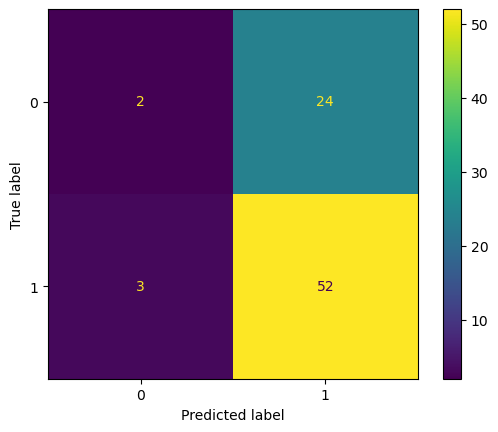

In [45]:
tn, fp, fn, tp = cm.ravel()
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Cross-Valitation Model on : Linear Support Vector Machine

A support vector machine constructs a hyperplane or set of hyperplanes in a high- or infinite-dimensional space, which can be used for classification, regression, or other tasks. Intuitively, a good separation is achieved by the hyperplane that has the largest distance to the nearest training-data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier. LinearSVC in Spark ML supports binary classification with linear SVM. Internally, it optimizes the Hinge Loss using OWLQN optimizer.

In [46]:
from pyspark.ml.classification import LinearSVC
lsvc = LinearSVC(featuresCol="indexedFeatures", labelCol="label", maxIter=50)

In [47]:
# Train the model for Linear Support Vector Machine model.  This also runs the indexers.
lsvc_model = lsvc.fit(trainingData)

In [48]:
# Make predictions on the Test Data
lsvc_predictions = lsvc_model.transform(testData)
# Select example rows to display. 
lsvc_predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|     indexedFeatures|       rawPrediction|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(630,[1,331,405,4...|    1|(630,[1,331,405,4...|[-0.7267874957847...|       1.0|
|(630,[3,202,364,3...|    0|(630,[3,202,364,3...|[-0.4134416141310...|       1.0|
|(630,[4,217,427,5...|    1|(630,[4,217,427,5...|[-0.3072110229268...|       1.0|
|(630,[5,359,456,5...|    1|(630,[5,359,456,5...|[-0.4313916204631...|       1.0|
|(630,[7,312,432,5...|    1|(630,[7,312,432,5...|[-0.4335250050648...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [49]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
lsvc_accuracy = evaluator.evaluate(lsvc_predictions)
print(f"Accuracy = {lsvc_accuracy}")
print("Test Error = %g" % (1.0 - lsvc_accuracy))

Accuracy = 0.7160493827160493
Test Error = 0.283951


### Get Confusion Matrix

In [50]:
y_pred=lsvc_predictions.select("prediction").collect()
y_orig=lsvc_predictions.select("label").collect()

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
cm = confusion_matrix(y_orig, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10 16]
 [ 7 48]]


In [52]:
tn, fp, fn, tp = cm.ravel()

false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
recall = recall_score(y_orig, y_pred)

print('For Linear Support Vector Machine :\n')
print('The false positive or type I error  rate is {}'.format(false_negative_rate))
print('The false negative or type II error rate is {}'.format(false_positive_rate))
print('The true negative or sensitivity    rate is {}'.format(true_negative_rate))
print('The true positive or recall         rate is {}'.format(recall))

For Linear Support Vector Machine :

The false positive or type I error  rate is 0.12727272727272726
The false negative or type II error rate is 0.6153846153846154
The true negative or sensitivity    rate is 0.38461538461538464
The true positive or recall         rate is 0.8727272727272727


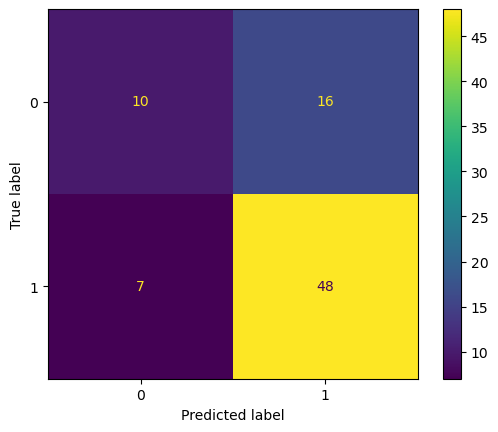

In [53]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Cross-Valitation Model on : Random Forest

Decision trees and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.

Random forests are ensembles of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. The spark.ml implementation supports random forests for binary and multiclass classification and for regression, using both continuous and categorical features.

In [54]:
from pyspark.ml.classification import RandomForestClassifier

random_forest = RandomForestClassifier(featuresCol='indexedFeatures', labelCol='label')

In [55]:
# Train the model for Random Forest model.  This also runs the indexers.
rf_model = random_forest.fit(trainingData)

In [56]:
# Make predictions on the Test Data
rf_predictions = rf_model.transform(testData)
# Select example rows to display. 
rf_predictions.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            features|label|     indexedFeatures|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|(630,[1,331,405,4...|    1|(630,[1,331,405,4...|[5.53436188646526...|[0.27671809432326...|       1.0|
|(630,[3,202,364,3...|    0|(630,[3,202,364,3...|[5.87405251918945...|[0.29370262595947...|       1.0|
|(630,[4,217,427,5...|    1|(630,[4,217,427,5...|[5.50803759705957...|[0.27540187985297...|       1.0|
|(630,[5,359,456,5...|    1|(630,[5,359,456,5...|[4.53436188646526...|[0.22671809432326...|       1.0|
|(630,[7,312,432,5...|    1|(630,[7,312,432,5...|[4.53436188646526...|[0.22671809432326...|       1.0|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [57]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
rf_accuracy = evaluator.evaluate(rf_predictions)
print(f"Accuracy = {rf_accuracy}")
print("Test Error = %g" % (1.0 - rf_accuracy))

Accuracy = 0.6790123456790124
Test Error = 0.320988


### Get Confusion Matrix

In [58]:
y_pred=lsvc_predictions.select("prediction").collect()
y_orig=lsvc_predictions.select("label").collect()

In [59]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
cm = confusion_matrix(y_orig, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10 16]
 [ 7 48]]


In [60]:
tn, fp, fn, tp = cm.ravel()

false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
recall = recall_score(y_orig, y_pred)

print('For Random Forest :\n')
print('The false positive or type I error  rate is {}'.format(false_negative_rate))
print('The false negative or type II error rate is {}'.format(false_positive_rate))
print('The true negative or sensitivity    rate is {}'.format(true_negative_rate))
print('The true positive or recall         rate is {}'.format(recall))

For Random Forest :

The false positive or type I error  rate is 0.12727272727272726
The false negative or type II error rate is 0.6153846153846154
The true negative or sensitivity    rate is 0.38461538461538464
The true positive or recall         rate is 0.8727272727272727


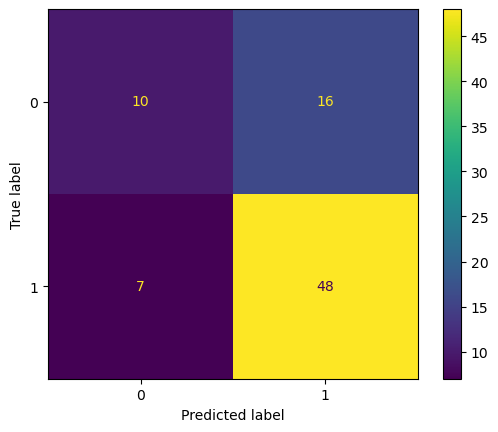

In [61]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Cross-Valitation Model on : Gradient Boosted Tree

Gradient-boosted trees (GBTs) are a popular classification and regression method using ensembles of decision trees. GBTs iteratively train decision trees in order to minimize a loss function. The spark.ml implementation supports GBTs for binary classification and for regression, using both continuous and categorical features.

In [62]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol='indexedFeatures', labelCol='label')

In [63]:
# Train the model for Random Forest model.  This also runs the indexers.
gbt_model = gbt.fit(trainingData)

In [64]:
# Make predictions on the Test Data
gbt_predictions = gbt_model.transform(testData)
# Select example rows to display. 
gbt_predictions.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+----------+
|            features|label|     indexedFeatures|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
|(630,[1,331,405,4...|    1|(630,[1,331,405,4...|[-1.5125704685059...|[0.04630292581796...|       1.0|
|(630,[3,202,364,3...|    0|(630,[3,202,364,3...|[0.89232949258011...|[0.85627120336067...|       0.0|
|(630,[4,217,427,5...|    1|(630,[4,217,427,5...|[-1.5220953053592...|[0.04546894507901...|       1.0|
|(630,[5,359,456,5...|    1|(630,[5,359,456,5...|[-1.5125704685059...|[0.04630292581796...|       1.0|
|(630,[7,312,432,5...|    1|(630,[7,312,432,5...|[-1.5125704685059...|[0.04630292581796...|       1.0|
+--------------------+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [65]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print(f"Accuracy = {gbt_accuracy}")
print("Test Error = %g" % (1.0 - gbt_accuracy))

Accuracy = 0.7283950617283951
Test Error = 0.271605


### Get Confusion Matrix

In [66]:
y_pred=lsvc_predictions.select("prediction").collect()
y_orig=lsvc_predictions.select("label").collect()

In [67]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, recall_score
cm = confusion_matrix(y_orig, y_pred)

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[10 16]
 [ 7 48]]


In [68]:
tn, fp, fn, tp = cm.ravel()

false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (tp + fn)
true_negative_rate = tn / (tn + fp)
recall = recall_score(y_orig, y_pred)

print('For Random Forest :\n')
print('The false positive or type I error  rate is {}'.format(false_negative_rate))
print('The false negative or type II error rate is {}'.format(false_positive_rate))
print('The true negative or sensitivity    rate is {}'.format(true_negative_rate))
print('The true positive or recall         rate is {}'.format(recall))

For Random Forest :

The false positive or type I error  rate is 0.12727272727272726
The false negative or type II error rate is 0.6153846153846154
The true negative or sensitivity    rate is 0.38461538461538464
The true positive or recall         rate is 0.8727272727272727


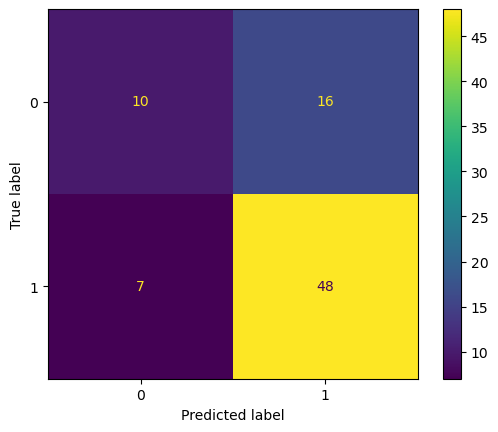

In [69]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## Conclusion of Spark ML Classifier

Let's review the accuracy of all the Spark ML Classifers:

In [70]:
print('The accuracy for each of the models are :')
print('\nNaive Bayes Analysis          :', nb_accuracy)
print('\nLogistic Regression           :', lg_accuracy)
print('\nLinear Support Vector Machine :', lsvc_accuracy)
print('\nRandom Forest                 :', rf_accuracy)
print('\nGradient Boosted Tree         :', gbt_accuracy)


The accuracy for each of the models are :

Naive Bayes Analysis          : 0.691358024691358

Logistic Regression           : 0.6666666666666666

Linear Support Vector Machine : 0.7160493827160493

Random Forest                 : 0.6790123456790124

Gradient Boosted Tree         : 0.7283950617283951


Based on all the accuracy rates from the various ML Classifiers, we see that Gradient Boosted Tree is the best option

### Final Conclusion: Graident Boosted Tree is the best option

In the future, I plan to do dimension reduction using PCA and SVD to run these again
If time permits, I will do that and submit the answer again